# Data preparation

The aim of this notebook is to read the grid of simulations and prepare files ready to be used by the training code. This should avoid the computation time which was spent at the beginning of each training reading and deprojecting the simulation results. 
Furthermore, in this way we separate the preprocessing of the data from the training code allowing to reuse the latter more easily.


## 1. Load the parameters file

In [1]:
import pandas as pd
import radiative_transfer as rt
para = pd.read_csv('../../data/datarun4/param_sampling/run4_complete.csv', index_col=0)
#para = pd.read_csv('params.csv', index_col=0)

## 2. Select the time of the desired dumps

In [2]:
orbits_time = 1500
label_time = int(orbits_time/50)

## 3. Load all the images projecting to cartesian coordinates and remove missing lines from the parameters' table

In [3]:
import oofargo
import numpy as np
from tqdm import tqdm 
import os
data_path = '../../data/datarun4/downf/'


In [4]:
def load_data():
    return np.array([[i, 
                  oofargo.open_img(
                      f'{data_path}out_{i:05}/dust1dens{label_time}.dat',
                      ntheta = para.loc[i, 'nx'].astype(int),
                      nr = para.loc[i, 'ny'].astype(int),
                      image_rmax = para.loc[i, 'rout'],
                      ylog = True
                  )]
                for i in tqdm(para.index.tolist())
                 if os.path.exists(f'{data_path}out_{i:05}/dust1dens30.dat')
                ])
    
def load_data_rt():
    return np.array([[i, 
                  rt.radiative_transfer(
                      f'{data_path}out_{i:05}/dust1dens{label_time}.dat',
                      para, 
                      i
                  )]
                for i in tqdm(para.index.tolist())
                 if os.path.exists(f'{data_path}out_{i:05}/dust1dens{label_time}.dat')
                ])

In [5]:
data = load_data_rt()

100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 24.37it/s]
/tmp/ipykernel_9301/241254320.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[i,


## 5. Remove images without a visible gap

In [6]:
import cv2

# return the maximum value for the log derivative between 0.6-2.4
def getmaxlogder(image, nx, ny, rmin, rmax, deproject=False):
    if isinstance(image, str):
        rho = oofargo.open_img(image, nr=ny, ntheta=nx, image_rmin=rmin, image_rmax=rmax, ylog=True)
    elif deproject:
        rho = cv2.warpPolar(image, (ny,nx), (64,64), 64, cv2.WARP_FILL_OUTLIERS )
    else:
        rho = image
    prof = np.log10(rho.mean(axis=0))
    y = np.log10(np.linspace(rmin, rmax, ny))
    
    der = (prof[1:]-prof[:-1])/(y[1:]-y[:-1])
    
    #remove part of the profile
    der_r = der[int((0.6-rmin)*ny/(rmax-rmin)):int((2.4-rmin)*ny/(rmax-rmin))]
    maxder = der_r.max()
    minder = der_r.min()
    
    return maxder

In [7]:
# removing objects without gaps: the selection is done on the data at time 1500
from scipy.ndimage import gaussian_filter
if orbits_time == 1500:
    para_n = para.loc[data[:,0]]
    for i, img in data:
        para_n.loc[i, f'maxder{orbits_time}'] = getmaxlogder(gaussian_filter(img, 2).transpose(), 
                                           para_n.loc[i, 'nx'].astype(int),
                                           para_n.loc[i, 'ny'].astype(int),
                                           0.4, para_n.loc[i, 'rout'], deproject=False)
    selected = para_n[para_n[f'maxder{orbits_time}']>0].sort_values(f'maxder{orbits_time}')
    para_n.to_csv('params.csv')
    selected.to_csv('selected.csv')
else:
    selected = pd.read_csv('selected.csv', index_col=0)

/tmp/ipykernel_9301/2371887917.py:11: RuntimeWarning: divide by zero encountered in log10
  prof = np.log10(rho.mean(axis=0))
/tmp/ipykernel_9301/2371887917.py:14: RuntimeWarning: invalid value encountered in subtract
  der = (prof[1:]-prof[:-1])/(y[1:]-y[:-1])


In [8]:
inputs = np.array([np.array([i, img], dtype=object) for i, img in data if i in selected.index.tolist()], dtype=object)

In [13]:
#setting plots for mnras
import matplotlib.pyplot as plt
import matplotlib
SMALL_SIZE=9
MEDIUM_SIZE=9
BIGGER_SIZE=9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.rm'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.it'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.bf'] = 'STIXGeneral'

import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
plt.rc('font', family=' Nimbus Roman')

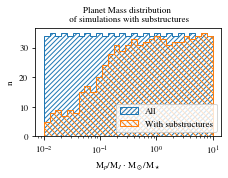

In [14]:
import matplotlib

plt.hist(para.loc[data[:,0],'PlanetMass']*10**3, histtype='step', hatch='/////', bins=np.logspace(-2,1,30), label='All')
plt.hist(selected['PlanetMass']*10**3,histtype='step', hatch="\\\\\\\\", bins=np.logspace(-2,1,30), label='With substructures')
plt.title('Planet Mass distribution \n of simulations with substructures')
plt.legend(loc='lower right')
plt.xscale('log')
plt.xlabel('M$_p/$M$_J$ $\cdot$ M$_\odot$/M$_\star$')
plt.ylabel('n')
plt.gcf().set_size_inches(10/3, 2)
plt.savefig('massdist.pdf', bbox_inches='tight')

## Augmentation 

In [11]:
# function used to extrapolate the density outside of the outer radius
def augment(image, nx, ny, rmin, rmax, rtarget, slope):
    
    #create new grid of r
    r = np.arange(rmin, rtarget, (rmax-rmin)/ny)
    new_ny = len(r)
    
    #extrapolate profile
    if new_ny < ny:
        return image[:new_ny, :], new_ny
    else:
        padded_im = np.pad(image, ((0, new_ny-ny),(0,0)),'constant', constant_values=(0,))
        rgrid = np.ones((new_ny, nx))*r.reshape(-1,1)
        prof = image[-1, :]*(rgrid/rmax)**(-slope)*(np.arange(0,new_ny,1)>ny-1).astype(int).reshape(-1,1)
        return prof+padded_im, new_ny

In [12]:
from scipy.ndimage import gaussian_filter
# function used to augment and warp the images
# Note: warp must be done before of the downsampling in order to avoid artefacts
def augment_and_warp(image, rtarg, nx, ny, rmin, rmax, slope, smooth=3):
    im_data, new_ny = augment(image, nx, ny, rmin, rmax, rtarg, slope)
    
    img =  oofargo.warp_image_rolltodisk(im_data, nx, new_ny, image_rmax = rtarg, target_rmax=4, target_image_size=(1280,1280))
    normalized = (img-img.mean())/(img.std())
    #norm_noisy = np.array(GaussianNoise(0.1*normalized.max())(normalized, True))
    img = gaussian_filter(cv2.resize(normalized, (128,128), interpolation=cv2.INTER_AREA), 2)   
    #imglog = img.copy()*(img>0.01).astype(int) + (img<=0.01).astype(int)*0.01
    #imglog = (np.log10(imglog)+2)/2
    return img

In [13]:
selected

,InvStokes1,Alpha,AspectRatio,FlaringIndex,PlanetMass,SigmaSlope,nx,rout,ny,maxder1500
627,881.048873,0.001435,0.093595,0.299775,0.000296,1.09955,600.0,3,193.0,0.006546
309,126.765187,0.000114,0.054115,0.054425,0.000013,0.60885,600.0,3,193.0,0.026093
761,26.001596,0.002223,0.099265,0.104475,0.000278,0.70895,600.0,3,193.0,0.030646
601,89.742879,0.000104,0.097375,0.091525,0.000087,0.68305,600.0,3,193.0,0.041852
223,43.551187,0.000452,0.076655,0.032375,0.000063,0.56475,600.0,3,193.0,0.108617
...,...,...,...,...,...,...,...,...,...,...
343,11.297959,0.000122,0.092895,0.175525,0.000427,0.85105,600.0,3,193.0,319.310724
762,10.115795,0.000299,0.035285,0.305725,0.000795,1.11145,890.0,3,286.0,325.825071
400,11.040786,0.000146,0.031435,0.023975,0.000028,0.54795,999.0,3,321.0,332.931263
320,13.396767,0.000259,0.036685,0.138075,0.000894,0.77615,856.0,3,276.0,335.583967


In [14]:
# split in 5 folds
from sklearn.model_selection import KFold

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=74)

splitted_data = {}
fold = 1
for train, test in kfold.split(inputs):
    for r_i in range(3):
        
        inputs_tr = np.array([
            augment_and_warp(img, 
                            rtarg = np.random.uniform(2.5+r_i*0.5, 3+r_i*0.5),
                            nx = selected.loc[i, 'nx'].astype(int),
                            ny = selected.loc[i, 'ny'].astype(int),
                            rmin = 0.4,
                            rmax = selected.loc[i, 'rout'],
                            slope = selected.loc[i, 'SigmaSlope']
                            ) for i, img in tqdm(inputs[train])])
        if r_i == 0:
            inputs_aug = inputs_tr
        else:
            inputs_aug = np.concatenate([inputs_aug, inputs_tr], axis=0)
        
    inputs_te = np.array([
            augment_and_warp(img, 
                            rtarg = np.random.uniform(2.5,4),
                            nx = selected.loc[i, 'nx'].astype(int),
                            ny = selected.loc[i, 'ny'].astype(int),
                            rmin = 0.4,
                            rmax = selected.loc[i, 'rout'],
                            slope = selected.loc[i, 'SigmaSlope']
                            ) for i, img in tqdm(inputs[test])])
    splitted_data[f'inp_train{fold}'] = inputs_aug
    splitted_data[f'inp_test{fold}'] = inputs_te
    splitted_data[f'targ_train{fold}'] = np.tile(np.log10(selected.loc[inputs[train, 0], 'PlanetMass'].tolist())+3, 3)
    splitted_data[f'targ_test{fold}'] = np.log10(selected.loc[inputs[test, 0], 'PlanetMass'].tolist())+3
    fold+=1

100%|█████████████████████████████████████████| 143/143 [00:03<00:00, 38.42it/s]


## 6. Save files
In an appropriate folder inside `training_data` there will be these files:

In [15]:
import os
folder = f'training_data/final{orbits_time}/'
os.mkdir(folder)
np.save(f'{folder}/data', splitted_data)